<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay

En esta tarea aplicaremos el procedimiento de predicción de precios de casas desarrollado en el libro [The Elements of Statistical Learning](https://link.springer.com/book/10.1007/ en la `sección 10.14.1 California Housing`.

Usaremos el modelo de aumento de gradiente **(Gradient Boosting)** para producir un modelo predictivo a partir de un conjunto de modelos predictivos débiles **(weak)**, usando la función **ensemble.GradientBoostingRegressor** de la librería **sklearn**. El **Gradient Boosting** se puede utilizar para problemas de regresión y clasificación. En esta tarea, entrenaremos un modelo de regresión para predecir demanda eléctrica usando datos de demanda de días semejantes. La variable independiente $X$ serán los datos de demanda del día anterior, y los datos independiente $Y$ serán los datos de días con una mayor correlación con $X$.

Los datos usados en esta sección están disponibles en [demanda.csv](https://drive.google.com/file/d/1KpY2p4bfVEwGRh5tJjMx9QpH6SEwrUwH/view?usp=sharing)


In [155]:
df    = pd.read_csv('demanda.csv')

## Procesamos datos de entrenamiento 
df1 = df.loc[df.iloc[:,20].isin(['T'])] ## 'T' = training set
df2 = df1['Y']  
df1 = df1[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13','X14','X15','X16','X17','X18']] ## Regresores
df1 = df1[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']] ## Regresores

## Procesamos datos de prueba 
dft = df.loc[df.iloc[:,20].isin(['F'])] ## 'F' = test set
dft2 = dft['Y']
dft1 = dft[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13','X14','X15','X16','X17','X18']] ## Regresores
dft1 = dft[['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10']] ## Regresores

X_train = df1.to_numpy()   ## Predictors
y_train = df2.to_numpy()   ## Outcome

X_test = dft1.to_numpy()   ## Predictors
y_test = dft2.to_numpy()   ## Outcome

Obtendremos los resultados con una función de pérdida por diferencia absoluta. Como parámetros del modelo usaremos 500 árboles de regresión `n_estimators=500`, con un número profundidad `max_depth=6` y una tasa de aprendizaje de `learning_rate": 0.01`.

In [156]:
params = { "n_estimators": 500,
           "max_depth": 6,
           "min_samples_split": 5,
           "learning_rate": 0.1,
           "loss": "absolute_error",} #"squared_error", "absolute_error", "huber", "quantile"

Ahora, ajustaremos un modelo **Gradient Boosting** con nuestros datos de entrenamiento. y calculamos el error cuadrático medio (MAE) en los datos de prueba.

In [157]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mae = mean_absolute_error(y_test, reg.predict(X_test))
print("El error medio absoluto (MAE) en datos de prueba es: {:.4f}".format(mae))

El error medio absoluto (MAE) en datos de prueba es: 173.8287


Ahora visualizaremos el proceso de ajuste con los datos de entrenamiento y prueba. Calcularemos el error del conjunto de datos de entrenamiento y luego la compararemos con las iteraciones del conjunto de datos de prueba.

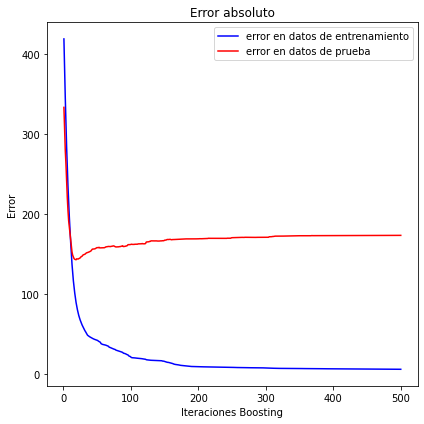

In [158]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Error absoluto")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="error en datos de entrenamiento",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="error en datos de prueba"
)
plt.legend(loc="upper right")
plt.xlabel("Iteraciones Boosting")
plt.ylabel("Error")
fig.tight_layout()
plt.show()

En la gráfica siguiente se muestra la importancia relativa de los predictores. Podemos observar  que los regresores `X11`, `X8` Y `X2` tienen una ligera importancia sobre los demás. Todas las demás variables tienen una relvancia ligeramente menos con un decremento monotónicamente decreciente. 



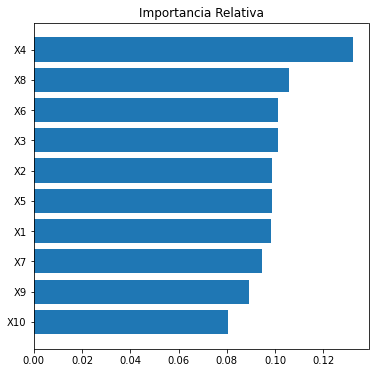

In [159]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(6, 6))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10'])[sorted_idx])
plt.title("Importancia Relativa")
plt.show()
print()

La dependencia de cada una de las variables la podemos analizar por medio de las figuras siguiente. Las discontibuidades que se observan en las figuras se deben al uso del modelo de árbol. 

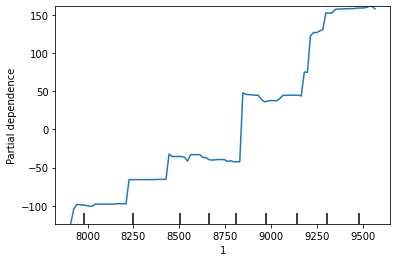

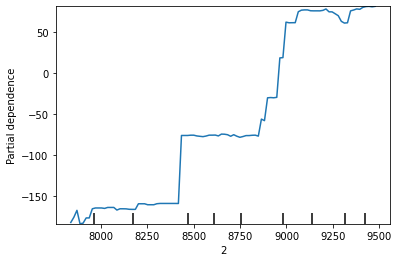

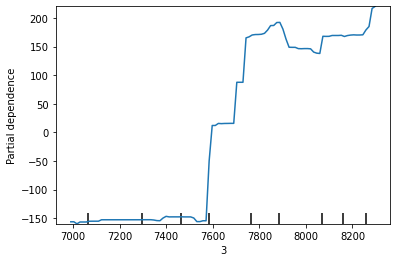

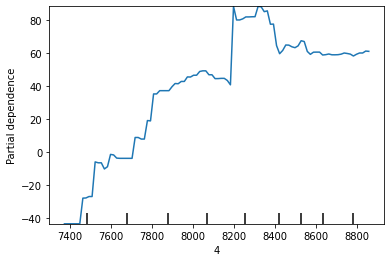

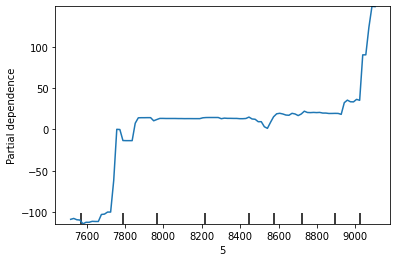

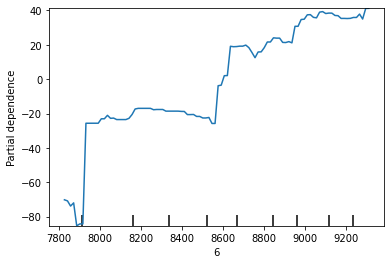

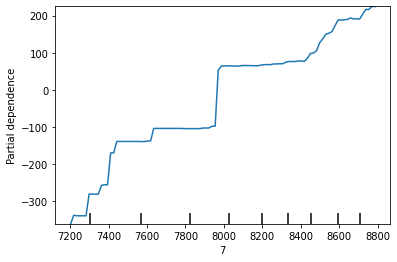

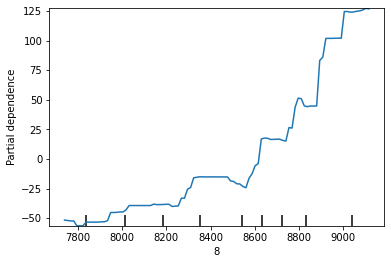

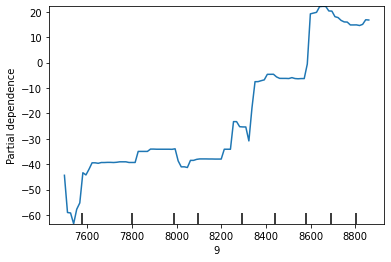

In [163]:
for features in [1,2,3,4,5,6,7,8,9]:
    PartialDependenceDisplay.from_estimator(reg, X_train, [features])

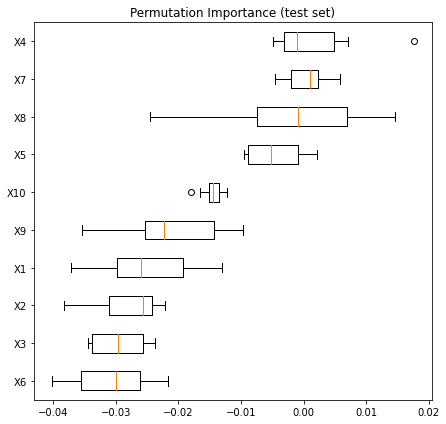

In [161]:
result = permutation_importance(reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
fig = plt.figure(figsize=(12, 6))
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
   result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(['X1','X2','X3','X4','X5','X6','X7','X8','X9','X10','X11','X12','X13','X14','X15','X16','X17','X18'])[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

### Ligas utilizadas

[Gradient Boosting regression](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html)

[sklearn.ensemble.GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)

[Partial dependence plots](https://scikit-learn.org/stable/modules/partial_dependence.html)
